In [305]:
import io
from google.cloud import vision
from google.cloud.vision import types

from tqdm import tqdm
import statistics

from PIL import Image
import imutils
import os

from zipfile import ZipFile

In [181]:
import cv2
import numpy as np

In [182]:
client = vision.ImageAnnotatorClient()

/home/shashvat/anaconda3/lib/python3.7/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [183]:
def get_response(filein, othermode = False):
    with io.open(filein, 'rb') as image_file:
        image = types.Image(content = image_file.read())
    response = None
    if othermode:
        response = client.text_detection(image=image)
    else:
        response = client.document_text_detection(image=image)
    return response

In [184]:
response = get_response("./test.jpg")

In [185]:
def assemble_word(word):
    assembled_word=""
    for symbol in word.symbols:
        assembled_word += symbol.text
    return assembled_word

def find_word_location(document, word_to_find):
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    assembled_word = assemble_word(word)
                    if(assembled_word == word_to_find):
                        yield word.bounding_box

In [186]:
locs = [loc for loc in find_word_location(response.full_text_annotation, "diagram")]

In [187]:
for i in range(0, len(locs), 2):
    l1 = locs[i]
    l2 = locs[i + 1]
    
    ystart = min(min([v.y for v in l1.vertices]), min([v.y for v in l2.vertices]))
    yend = max(max([v.y for v in l1.vertices]), max([v.y for v in l2.vertices]))
    
    print(ystart, yend)

938 1770


In [278]:
original = Image.open("./demo/7.012noteslindrew-0.png")
# original = Image.open("./convert/7.012noteslindrew-0.png")

In [279]:
original.size

(3024, 4032)

In [282]:
top = original.crop((0, 0 + 938, 0 + original.size[0], 1600))

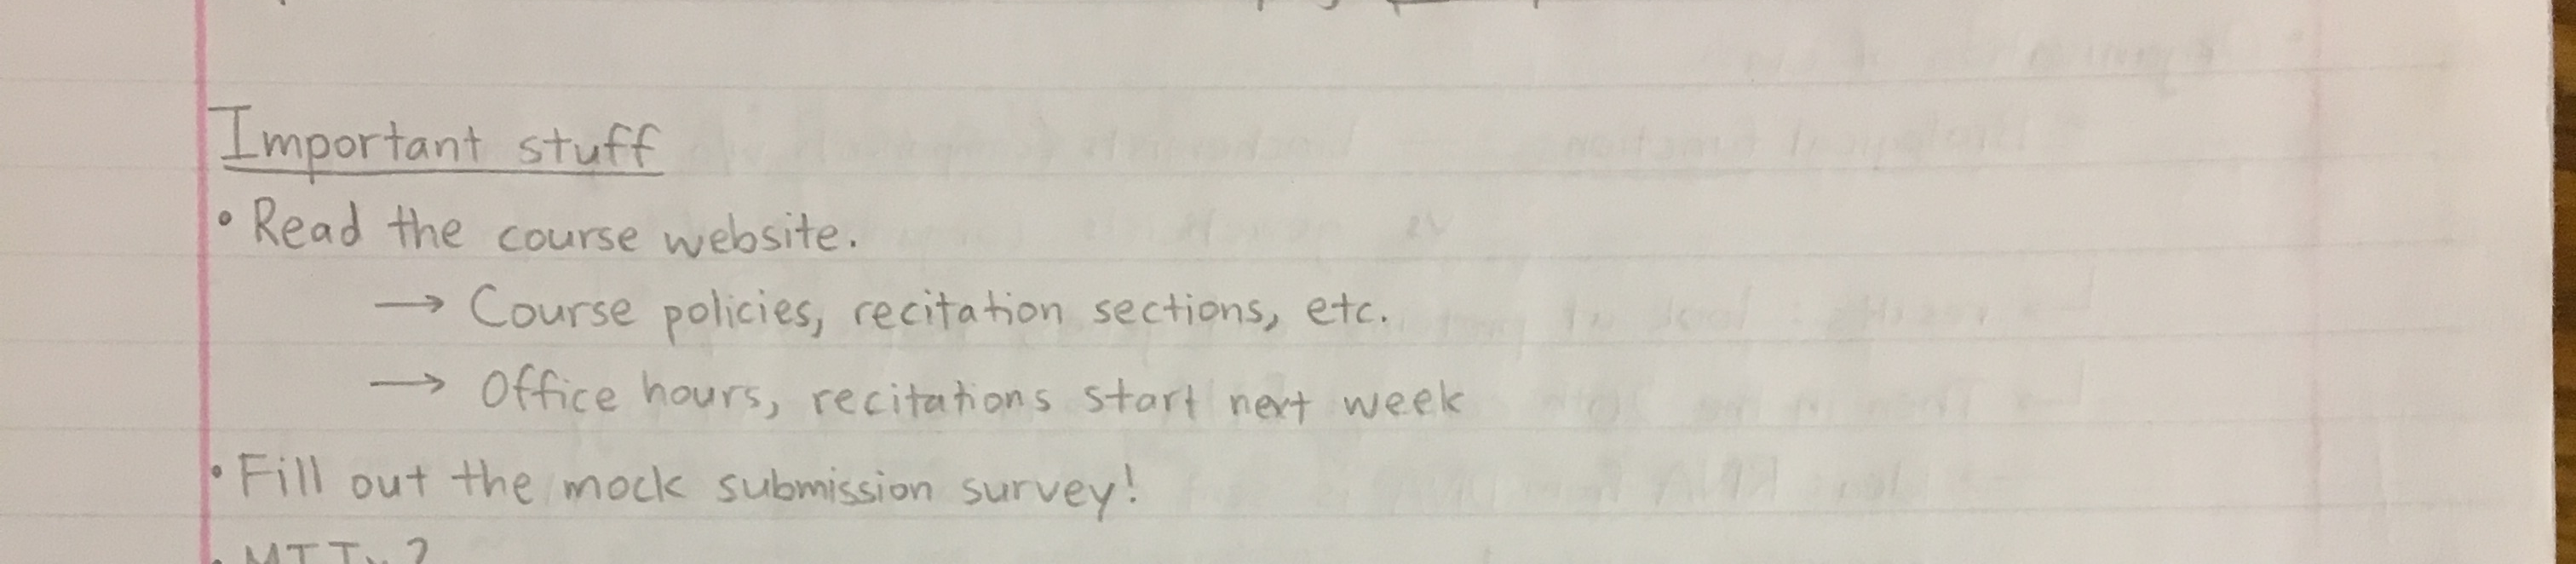

In [283]:
top

In [214]:
ylast = 0
crops = []
for i in range(0, len(locs), 2):
    l1 = locs[i]
    l2 = locs[i + 1]
    
    ystart = min(min([v.y for v in l1.vertices]), min([v.y for v in l2.vertices]))
    yend = max(max([v.y for v in l1.vertices]), max([v.y for v in l2.vertices]))
    
    top = original.copy().crop((0 + ylast, 0, 0 + ystart, original.size[1]))
    crops.append(top)
    
    ylast = yend
    print(ystart, yend)
    
top = original.copy().crop((ylast, 0, original.size[0], original.size[1]))
crops.append(top)

938 1770


In [287]:
special = "&%$#_{}~^\\"
special_map = {}
for s in special:
    special_map[s] = "\\" + s
special_map["~"] = "\\textasciitilde"
special_map["^"] = "\\textasciicircum"
special_map["\\"] = "\\textbackslash"
special_map["["] = "{[}"
special_map["]"] = "{]}"

def parse_sym(s):
    if s in special_map.keys():
        return special_map[s]
    return s

def parse_detected_break(text, detected_break, in_itemize = False):
    break_text = ""
    kind = detected_break.type
    
    if kind:
        if kind == 1:
            break_text = " "
        elif kind == 2:
            break_text = "    "
        elif kind == 3:
            if in_itemize:
                break_text = "\n"
            else:
                break_text = "\\\\\n"
#             break_text = "$3\n"
        elif kind == 5:
            if in_itemize:
                break_text = "\n"
            else:
                break_text = "\\\\\n"
#             break_text = "$5\n"
#         elif kind == 2:
#             break_text = " "
        
#         elif 

    if detected_break.is_prefix:
        return break_text + text
    else:
        return text + break_text

def avg_sym_width(block):
    widths = []
    for paragraph in block.paragraphs:
        for word in paragraph.words:
            for sym in word.symbols:
                widths.append(sym.bounding_box.vertices[1].x - sym.bounding_box.vertices[0].x)
    if len(widths) == 0:
        return 0
    return statistics.median(widths)

def avg_sym_heights(document):
    widths = []
    for page in document.pages:
        for block in page.blocks:
            for paragraph in block.paragraphs:
                for word in paragraph.words:
                    for sym in word.symbols:
                        widths.append(sym.bounding_box.vertices[2].y - sym.bounding_box.vertices[0].y)
    if len(widths) == 0:
        return 0    
    return statistics.median(widths)

def avg_sym_height_block(block):
    widths = []
    for paragraph in block.paragraphs:
        for word in paragraph.words:
            for sym in word.symbols:
                widths.append(sym.bounding_box.vertices[2].y - sym.bounding_box.vertices[0].y)
    if len(widths) == 0:
        return 0
    return statistics.median(widths)

def get_raw(block):
    b = ""
    for p in block.paragraphs:
        for w in p.words:
            for s in w.symbols:
                b += s.text
    return b

def extract_block(block):
    avg_width = avg_sym_width(block)
    
    b = ""
    
    in_itemize = False
    itemize_levels = 0
    last_itemize = None
    
    for paragraph in block.paragraphs:
        p = ""
        for word in paragraph.words:
            w = ""
            for symbol in word.symbols:
#                 print(symbol.property.detected_languages)
                detected_break = symbol.property.detected_break
                text = parse_sym(symbol.text)
                
                if text == "." and (p == "1" or p == "|"):
                    p = ""
                    text = "•"
                elif len(p) >= 2 and p[-2:] == "\n1":
                    text = "•"
                    p = p[:-1]
                    
                washere = False
                if text in "•-" and (p == "" or p[-1] == '\n'):
                    washere = True
                    
                    text = ""
                    if not in_itemize:
                        text += "\\begin{itemize}\n"
                        in_itemize = True
                        itemize_levels += 1
                    if in_itemize:
                        text += "\\item "
                        
                    if last_itemize and itemize_levels <= 3:
                        dist = symbol.bounding_box.vertices[0].x - last_itemize.bounding_box.vertices[0].x
                        
                        y1 = [last_itemize.bounding_box.vertices[0].y, last_itemize.bounding_box.vertices[2].y]
                        y2 = [symbol.bounding_box.vertices[0].y, symbol.bounding_box.vertices[2].y]
            
                        inter = set(range(y1[0], y1[1])).intersection(set(range(y2[0], y2[1])))
                        if dist >= 4 * avg_width:
                            text = "\\begin{itemize}\n" + text
                            itemize_levels += 1
                            in_itemize = True
                        elif dist <= -4 * avg_width and itemize_levels >= 2:
                            text = "\\end{itemize}\n" + text
                            itemize_levels -= 1
                            in_itemize = (itemize_levels != 0)
                
                    last_itemize = symbol
                w += parse_detected_break(text, detected_break, in_itemize)
                
            if in_itemize and "\\item" not in w:
                if p != "" and p[-1] == '\n':
                    for _ in range(itemize_levels):
                         p += "\\end{itemize}\n"
                    itemize_levels = 0
                    in_itemize = False
                    last_itemize = None
                
            p += parse_detected_break(w, word.property.detected_break, in_itemize)
        
        b += parse_detected_break(p, paragraph.property.detected_break, in_itemize)
        
    if in_itemize:
        for _ in range(itemize_levels):
             b += "\\end{itemize}\n"
        
        itemize_levels = 0
        in_itemize = False
        last_itemize = None
        
    text = parse_detected_break(b, block.property.detected_break)
    text = text.replace("\\\\\\begin{itemize}", "\\begin{itemize}")
    text = text.replace("\\\\\n\\begin{itemize}", "\n\\begin{itemize}")
#     text = text.replace("\\\\\\begin{itemize}")
#     text = text.replace("\\end{itemize}\n\\begin{itemize}", "")
    return text

In [306]:
def run(file, outfile, z):
    response = get_response(file)
    ores = response
    locs = [loc for loc in find_word_location(response.full_text_annotation, "Diagram")]
    print(len(locs))
    original = Image.open(file)
    
    ylast = 0
    crops = []
    for i in range(0, len(locs), 2):
        if i + 1 == len(locs):
            continue
            
        print(i)
        
        l1 = locs[i]
        l2 = locs[i + 1]
        
        ystart = min(min([v.y for v in l1.vertices]), min([v.y for v in l2.vertices]))
        yend = max(max([v.y for v in l1.vertices]), max([v.y for v in l2.vertices]))
        
        top = original.copy().crop((0, ylast, 0 + original.size[0], ystart))
        crops.append(top)
        
        bot = original.copy().crop((0, ystart, original.size[0], yend))
        bot.save("qq{}.png".format(i), "PNG")
        
        ylast = yend
        print(ystart, yend)
        
    top = original.copy().crop((0, ylast, original.size[0], original.size[1]))
    crops.append(top)   
    
    zipfiles = [outfile]
    zipObj = ZipFile(z, 'w')
    
    with open(outfile, "w") as f:
        fmt = open("format.tex", "r").read()
        al = ""
        
        for i, crop in enumerate(crops):
            crop.load()
            crop.save("crop.png", "PNG")
            
            response = get_response("crop.png")
            locs = [loc for loc in find_word_location(response.full_text_annotation, "Diagram")]
            print(locs)
                    
            avg_height = avg_sym_heights(response.full_text_annotation)
            for page in response.full_text_annotation.pages:
                for block in page.blocks:
                    height = avg_sym_height_block(block)
                    if height >= 1.9 * avg_height:
#                     if "lecture" in get_raw(block):
                        al += "\\newpage \n \\section{" + get_raw(block) + "}"
                    else:
                        text = extract_block(block)
                        al += text
                    
            if os.path.exists(os.path.join(os.getcwd(), "qq{}.png".format(i))):
                zipfiles.append("qq{}.png".format(i))
                al += """
                        \\begin{figure}[H]
                        \includegraphics[width=0.9\\textwidth]{qq""" + str(i) + """.png}
                        \\end{figure}
                        """
                
        text = fmt + al + "\\end{document}"
        f.write(text)
    for f in zipfiles:
        zipObj.write(f)
    zipObj.close()
        

In [307]:
run("./demo/7.012noteslindrew-0.png", "plswork.tex", "plszip.zip")

2
0
3325 3967
[]
[]


In [316]:
def run(files, outfile, z):
    zipfiles = [outfile]
    zipObj = ZipFile(z, 'w')
    
    fmt = open("format.tex", "r").read()
    al = ""
    
    for filenum, file in enumerate(files):
        response = get_response(file)
        ores = response
        locs = [loc for loc in find_word_location(response.full_text_annotation, "Diagram")]
        print(len(locs))
        original = Image.open(file)

        ylast = 0
        crops = []
        for i in range(0, len(locs), 2):
            if i + 1 == len(locs):
                continue

            print(i)

            l1 = locs[i]
            l2 = locs[i + 1]

            ystart = min(min([v.y for v in l1.vertices]), min([v.y for v in l2.vertices]))
            yend = max(max([v.y for v in l1.vertices]), max([v.y for v in l2.vertices]))

            top = original.copy().crop((0, ylast, 0 + original.size[0], ystart))
            crops.append(top)

            bot = original.copy().crop((0, ystart, original.size[0], yend))
            bot.save("q{}q{}.png".format(filenum, i), "PNG")

            ylast = yend
            print(ystart, yend)

        top = original.copy().crop((0, ylast, original.size[0], original.size[1]))
        crops.append(top)   

        with open(outfile, "w") as f:


            for i, crop in enumerate(crops):
                crop.load()
                crop.save("crop.png", "PNG")

                response = get_response("crop.png")
                locs = [loc for loc in find_word_location(response.full_text_annotation, "Diagram")]
                print(locs)

                avg_height = avg_sym_heights(response.full_text_annotation)
                for page in response.full_text_annotation.pages:
                    for block in page.blocks:
                        height = avg_sym_height_block(block)
                        if height >= 1.9 * avg_height:
#                         if "lecture" in get_raw(block):
                            al += "\\newpage \n \\section{" + get_raw(block) + "}"
                        else:
                            text = extract_block(block)
                            al += text

                if os.path.exists(os.path.join(os.getcwd(), "q{}q{}.png".format(filenum, i))):
                    zipfiles.append("q{}q{}.png".format(filenum, i))
                    al += """
                            \\begin{figure}[H]
                            \includegraphics[width=0.9\\textwidth]{""" + "q{}q{}.png".format(filenum, i) + """}
                            \\end{figure}
                            """
            
    text = fmt + al + "\\end{document}"
    with open(outfile, "w") as f:
        f.write(text)
    for f in zipfiles:
        zipObj.write(f)
    zipObj.close()


In [317]:
run(["./demo/7.012noteslindrew-0.png", "./demo/7.012noteslindrew-0.png", "./demo/7.012noteslindrew-0.png", "./demo/7.012noteslindrew-0.png"], "plswork.tex", "plszip.zip")

2
0
3325 3967
[]
[]
2
0
3325 3967
[]
[]
2
0
3325 3967
[]
[]
2
0
3325 3967
[]
[]
